In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
# PART 1 Variable Evaluation
dataset = pd.read_csv('titanic_train.csv')
dataset.drop('PassengerId',axis = 1, inplace = True)

#Embarked missing value : only 2 missing, use mode here, but in the later prerprocessing, more detail will be considered.
Embark_mode = dataset['Embarked'].mode()[0]
dataset['Embarked'].fillna(value = Embark_mode, inplace = True)
# sex -> numercial
dataset['Sex'][dataset['Sex']=='male']=1
dataset['Sex'][dataset['Sex']=='female']=0
dataset['Sex'] = dataset['Sex'].astype(np.int64) 

# name : extract the title from name using regex
pattern = re.compile('\w+, (.+?)[.]')
dataset['Title'] = 'None'
for i in range(0,len(dataset['Name'])):
    try:    
        dataset['Title'][i] = re.search(pattern,list(dataset['Name'].values)[i]).group(1) 
    except:
        continue       


# Family Name
pattern_fname = re.compile('(.+),')        
dataset['Surname'] = 'None'   
for m in range(0,len(dataset['Name'])):
    try:    
        dataset['Surname'][m] = re.search(pattern_fname,list(dataset['Name'].values)[m]).group(1) 
    except:
        continue  
    
fname_count = dataset['Surname'].value_counts()
fname_labels = list(dataset['Surname'].unique())
fname_dict = dict()
for n in range(0,len(fname_labels)):
    fname_dict.update(dict.fromkeys([fname_labels[n]],fname_count.loc[fname_labels[n]]))

dataset['Surname'] = dataset['Surname'].map(fname_dict)

dataset.drop('Name',axis=1,inplace = True)



# for age, use Random Forest to predict missing value first
age_set = dataset[['Age','Survived','Pclass','Sex','SibSp','Parch','Fare']]
X_train = age_set[age_set['Age'].notnull()].iloc[:,1:].values
X_test = age_set[age_set['Age'].isnull()].iloc[:,1:].values
Y_train =age_set[age_set['Age'].notnull()].iloc[:,0].values

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators= 1000,random_state = 0)
regressor.fit(X_train,Y_train)

Y_pred = regressor.predict(X_test)
Y_pred = np.round(Y_pred,0)
 
dataset.loc[dataset['Age'].isnull(),'Age'] = Y_pred

dataset.info()

E:\MNCD\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
E:\MNCD\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
E:\MNCD\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\MNCD\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    891 non-null object
Title       891 non-null object
Surname     891 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 83.6+ KB


E:\MNCD\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


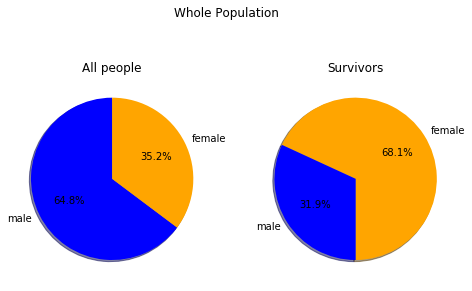

In [2]:
# Variable Evaluation:
# 1. Sex and Survival Rate
# Among all the people, the proportion of sex:
#Total population Comparison
total = dataset['Sex']
total[total==0]='female'
total[total==1]='male'
total = total.value_counts()

# Among Survivors
sex_sur = dataset['Sex'][dataset['Survived']==1]
sex_sur[sex_sur==0] ='female'
sex_sur[sex_sur==1] ='male'
sex_sur = sex_sur.value_counts()

fig,ax = plt.subplots(1,2,figsize = (8,5))
label0 = ['male','female']
label1 = ['female','male']
fig.suptitle('Whole Population')
ax[0].pie(total,autopct='%1.1f%%',labels = label0,colors = ['blue','orange'],startangle = 90,shadow=True)
ax[0].set_title('All people')
ax[1].pie(sex_sur,autopct='%1.1f%%',labels = label1,colors = ['orange','blue'],startangle = -90,shadow=True)
ax[1].set_title('Survivors')
plt.show()
# While the majority of the population were male, more female survived'''

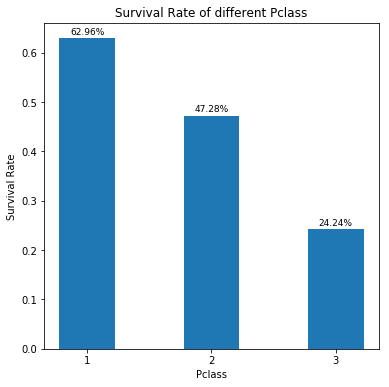

In [3]:
# 2. Pclass and Survival Rate
# Compare the survival rate among different pclasses
pc = dataset[['Pclass','Survived']].groupby('Pclass').mean()
pc.reset_index(inplace = True)
#plt.figure(figsize = ())
bar_width = 0.15
ind = np.arange(0.2,1.19,1/3)

plt.figure(figsize = (6,6))
plt.bar(ind,pc['Survived'],width = bar_width) 
plt.xticks(ind,labels = pc['Pclass'])
for i in range(0,len(pc['Pclass'])):
    plt.text(ind[i],pc['Survived'][i]+0.008,str(round(100*pc['Survived'][i],2))+'%',ha = 'center',size = 9,)
plt.title('Survival Rate of different Pclass')
plt.xlabel('Pclass')
plt.ylabel('Survival Rate')
plt.show()

E:\MNCD\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


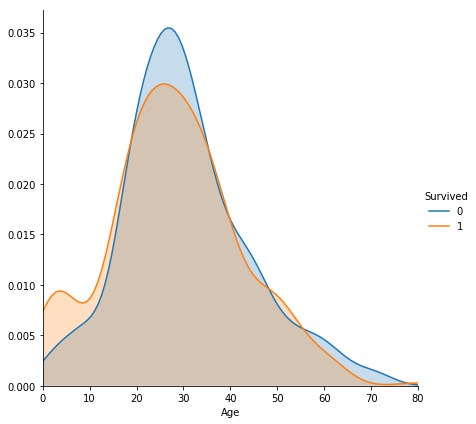

In [4]:
# 3. Age ~ Pclass and Sex

facet = sns.FacetGrid(data = dataset,hue = 'Survived',size = 6)
facet.map(sns.kdeplot,'Age',shade = True)
facet.set(xlim=(0,max(dataset['Age'][dataset['Age'].notnull()])))
facet.add_legend()
plt.show()

# children has the higher probability of surviving while adults are more likely to die in this disaster

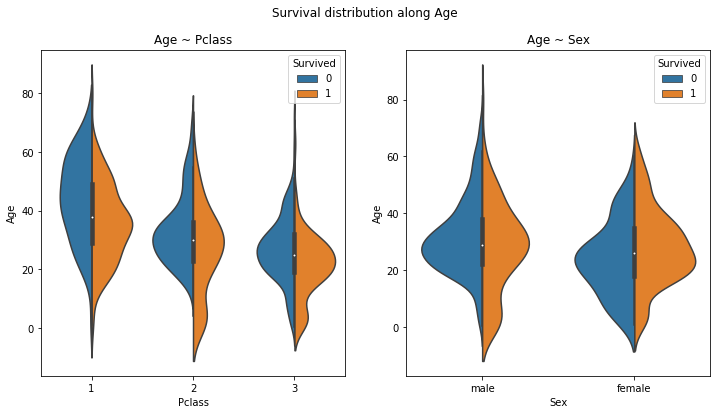

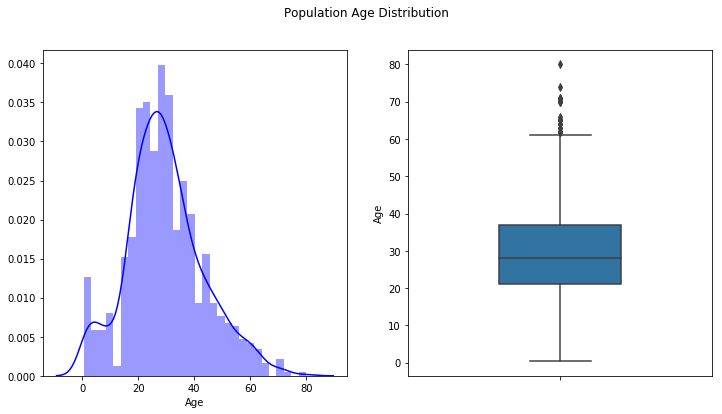

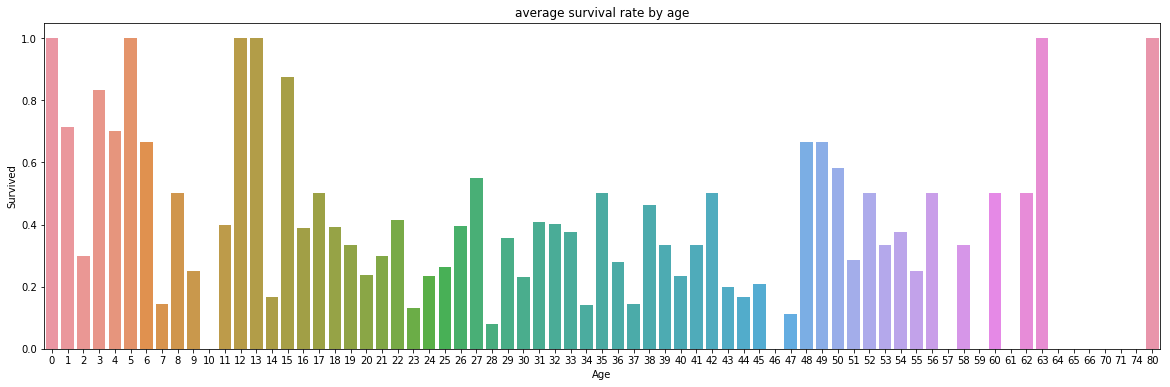

In [5]:
fig,ax = plt.subplots(1,2,figsize = (12,6))
fig.suptitle('Survival distribution along Age')

sns.violinplot('Pclass','Age',hue = 'Survived',data = dataset, split = True,ax = ax[0])
ax[0].set_title('Age ~ Pclass')
ax[0].set_yticks(range(0,100,20))
 
sns.violinplot('Sex','Age',hue = 'Survived',data = dataset, split = True,ax = ax[1])
ax[1].set_title('Age ~ Sex')
ax[1].set_yticks(range(0,100,20))
plt.show()

#Then compare the shape with population Age distribution
fig,ax = plt.subplots(1,2,figsize = (12,6))
fig.suptitle('Population Age Distribution')
sns.distplot(dataset['Age'],bins = 30, hist = True, kde = True,ax = ax[0],color = 'blue')

sns.boxplot(y='Age',data = dataset,ax=ax[1], width = 0.4)
plt.show()
# Same distribution 


# average survival rate by age
dataset['Age'] = dataset['Age'].apply(lambda x:round(x,2))

dataset['Age'] = dataset['Age'].apply(str)
age_ave = dataset[['Age','Survived']].groupby('Age').mean()
age_ave.reset_index(inplace = True)
age_ave['Age'] = age_ave['Age'].apply(float)
age_ave.sort_values('Age',inplace = True)
age_ave['Age'] = age_ave['Age'].apply(int)
dataset['Age'] = dataset['Age'].apply(str)

plt.figure(figsize = (20,6))
sns.barplot('Age','Survived',data = age_ave,ci=1)
plt.title('average survival rate by age')
plt.show()
#children and older people are more likely to survive

E:\MNCD\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
E:\MNCD\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


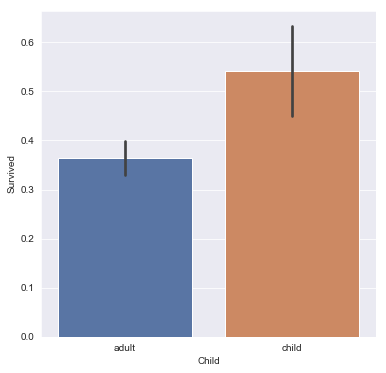

In [6]:
# from the survival rate distribution, it's clear that people under age 15(child) have higher rate of surviving
#divide into adult(>15) and child(<=15) groups:
dataset['Child'] = 'None'
dataset['Age'] = dataset['Age'].apply(np.float64)
dataset['Child'][dataset['Age']>15]='adult'
dataset['Child'][dataset['Age']<=15]='child'
sns.set({'figure.figsize':(6,6)})
sns.barplot('Child','Survived',data  = dataset)
plt.show()
# children have higher surv-rate

E:\MNCD\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\MNCD\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\MNCD\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

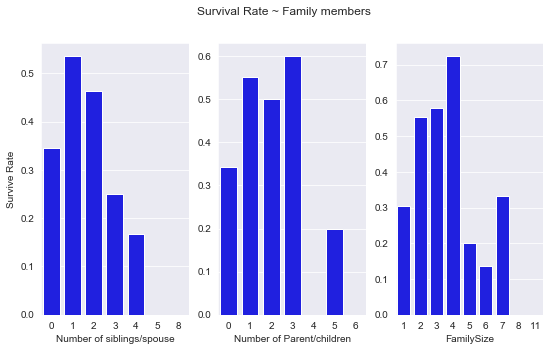

In [7]:
# Sib/sp and Par/ch
sibsp = dataset[['SibSp','Survived']]
sibsp['SibSp'] = sibsp['SibSp'].apply(str)
sibsp_sur = sibsp.groupby('SibSp').mean()
sibsp_sur.reset_index(inplace = True)

parch= dataset[['Parch','Survived']]
parch['Parch'] = parch['Parch'].apply(str)
parch_sur = parch.groupby('Parch').mean()
parch_sur.reset_index(inplace = True)

# create new variable: family size = sum of these two
dataset['FamilySize'] = dataset['SibSp']+dataset['Parch']+1
fam= dataset[['FamilySize','Survived']]
fam['FamilySize'] = fam['FamilySize'].apply(str)
fam_sur = fam.groupby('FamilySize').mean()
fam_sur.reset_index(inplace = True)
fam_sur['FamilySize'] = fam_sur['FamilySize'].apply(int)
fam_sur.sort_values('FamilySize',inplace = True)
fam_sur['FamilySize'] = fam_sur['FamilySize'].apply(str)
fam_sur.reset_index(inplace = True)
fam_sur.drop('index',axis=1,inplace = True)

# plot
fig,ax = plt.subplots(1,3,figsize = (9,5))
fig.suptitle('Survival Rate ~ Family members')
sns.barplot('SibSp','Survived',data = sibsp_sur,ax=ax[0],ci=0,color = 'blue')
ax[0].set_xlabel('Number of siblings/spouse')
ax[0].set_ylabel('Survive Rate')

sns.barplot('Parch','Survived',data = parch_sur,ax=ax[1],ci=0,color = 'blue')
ax[1].set_xlabel('Number of Parent/children')
ax[1].set_ylabel(' ')

sns.barplot('FamilySize','Survived',data = fam_sur,ax=ax[2],ci=0,color = 'blue',order =fam_sur['FamilySize'])
ax[2].set_xlabel('FamilySize')
ax[2].set_ylabel(' ')
plt.show()




In [8]:
# We can see from the bar plot that family size 2-4,1 or 5,6,7, more than 7,  have quite a big gap in survival rate
# Therefore, try to divide familysize into three classes: 0(>7), 1(1,5,6,7), 2(2,3,4)
#dataset['FamilySize'] = dataset['FamilySize'].apply(int)
dataset['FamilySize'][dataset['FamilySize']>7]=0
dataset['FamilySize'][(dataset['FamilySize']==1)|((dataset['FamilySize']>=5)&(dataset['FamilySize']<=7))]=1
dataset['FamilySize'][(dataset['FamilySize']>=2)&(dataset['FamilySize']<=4)]=2

E:\MNCD\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
E:\MNCD\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
E:\MNCD\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


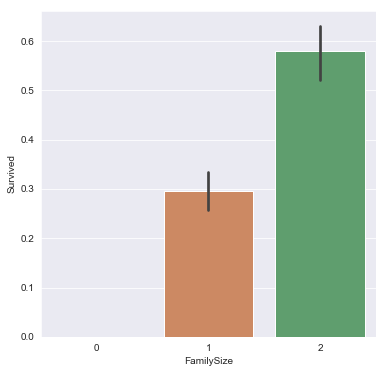

In [9]:
dataset['FamilySize'] = dataset['FamilySize'].apply(str)
sns.barplot('FamilySize','Survived',data = dataset)
plt.show()
#Obviously, people with 2-4 family size(medium) are more likely to survive, while the survival rate of other classes are low.

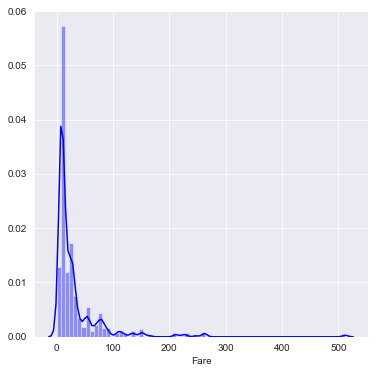

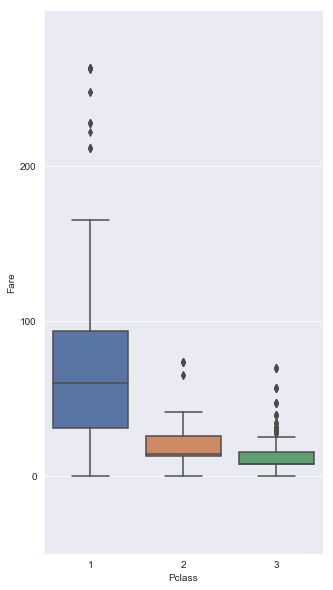

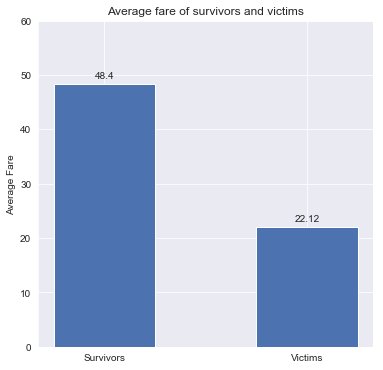

In [10]:
# Fare
# distribution
fare = dataset['Fare']
sns.distplot(fare,bins=70,color = 'blue')
plt.show()

# Compare the average fare between differnet pclass
fare_pc = dataset[['Fare','Pclass']]
plt.figure(figsize = (5,10))
sns.boxplot('Pclass','Fare',data = fare_pc)
plt.ylim([-50,300])
plt.yticks(range(0,300,100))
plt.show()
# pclass1>2>3  pclass 1 is the most high-end

# compare the mean fare of survivors and victims
fare_surv = dataset[dataset['Survived']==1]['Fare'].mean()
fare_vict = dataset[dataset['Survived']==0]['Fare'].mean()
ind = [0.5,0.7]
fare_y = [fare_surv,fare_vict]
plt.bar(ind,fare_y,width = 0.1)
plt.xticks(ind,['Survivors','Victims'])
for i in range(0,2):
    plt.text(ind[i],fare_y[i]+1,round(fare_y[i],2),size =10,ha = 'center')
plt.ylabel('Average Fare')
plt.ylim([0,60])
plt.title('Average fare of survivors and victims')
plt.show()


<Figure size 432x432 with 0 Axes>

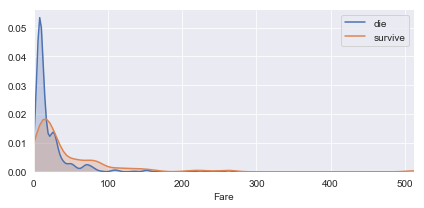

In [11]:
plt.figure()
facet_fare = sns.FacetGrid(data = dataset,hue = 'Survived',aspect = 2)
facet_fare.map(sns.kdeplot,'Fare',shade = True)
facet_fare.set(xlim = (0,max(dataset['Fare'])))
plt.legend(labels=['die','survive'])
plt.show()

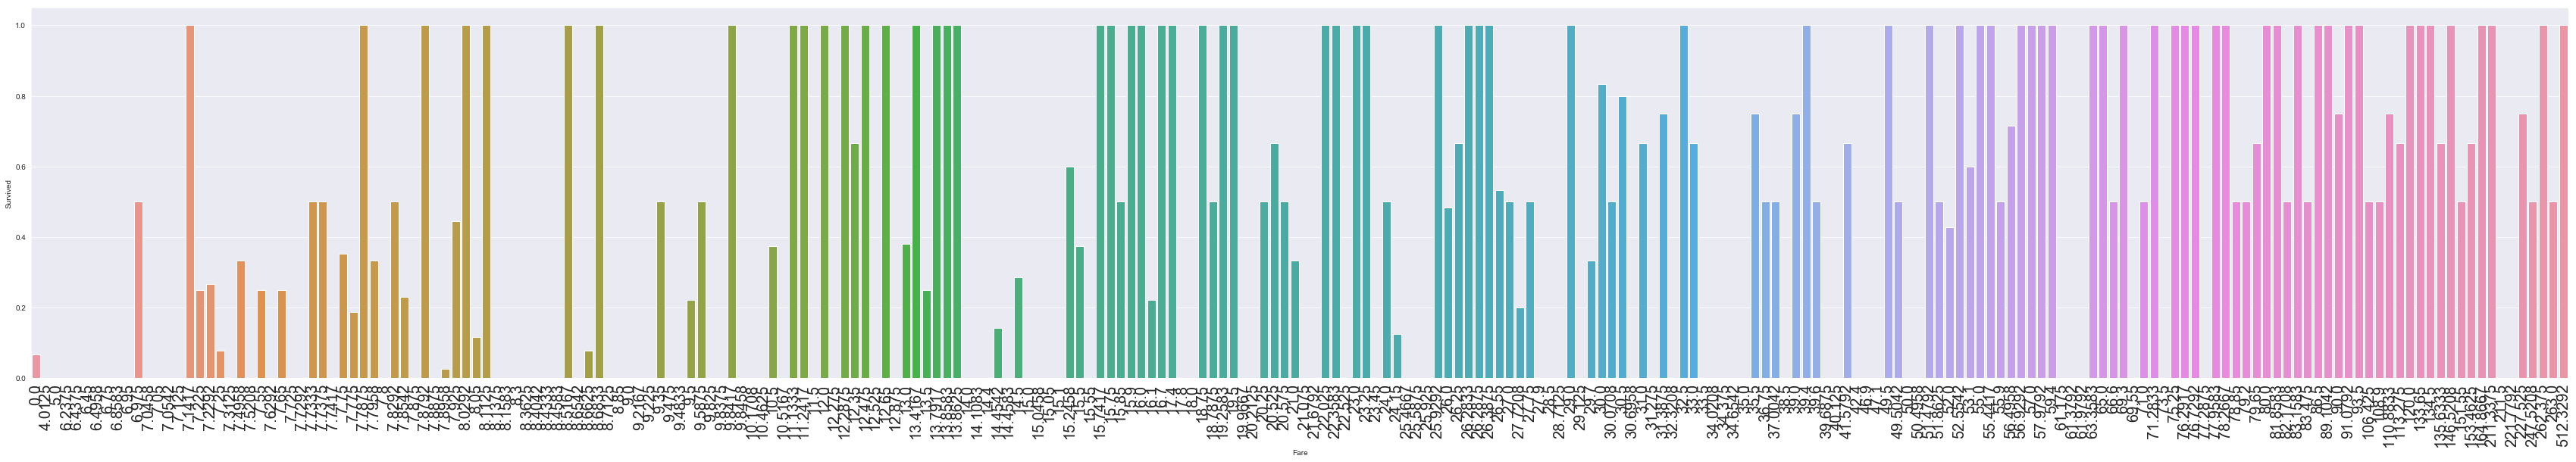

In [12]:
sns.set({'figure.figsize':(60,9)})
sns.barplot(x = 'Fare',y = 'Survived',data = dataset,ci=0)
plt.xticks(rotation = 90,size=20)
plt.show()

E:\MNCD\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
E:\MNCD\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\MNCD\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\MNCD\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarn

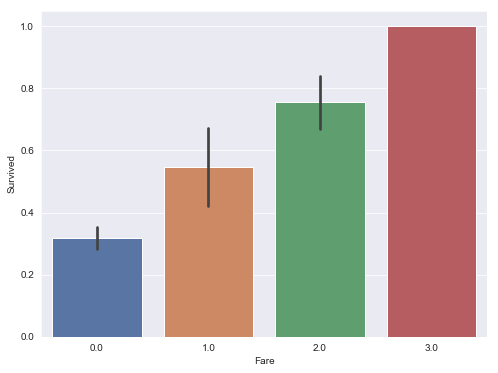

In [13]:
dataset['Fare'][dataset['Fare']<50]=0
dataset['Fare'][(dataset['Fare']>=50)&(dataset['Fare']<74)]=1
dataset['Fare'][(dataset['Fare']>=74)&(dataset['Fare']<300)]=2
dataset['Fare'][dataset['Fare']>=300]=3

sns.set({'figure.figsize':(8,6)})
sns.barplot('Fare','Survived',data = dataset)

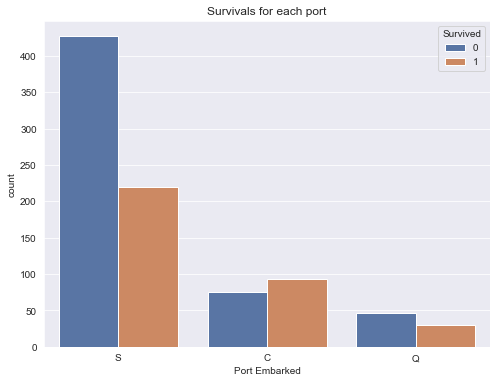

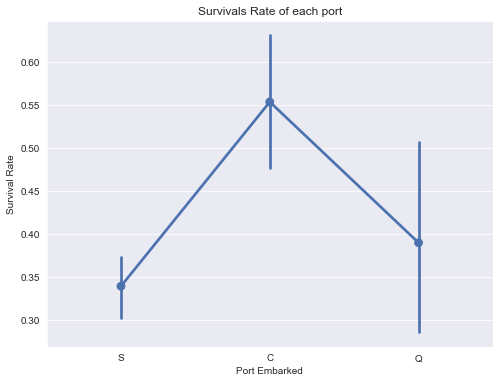

In [14]:
#Embarked: sur/vict for each port
sns.countplot('Embarked',hue = 'Survived', data = dataset)
plt.title('Survivals for each port')
plt.xlabel('Port Embarked')
plt.show()

sns.pointplot(x = 'Embarked',y = 'Survived',data = dataset)
plt.title('Survivals Rate of each port')
plt.xlabel('Port Embarked')
plt.ylabel('Survival Rate')
plt.show()
# port C has the highest survival rate



E:\MNCD\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


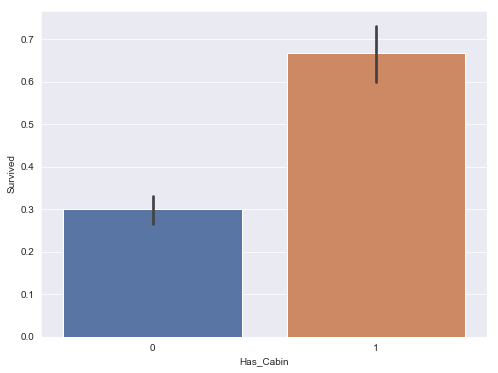

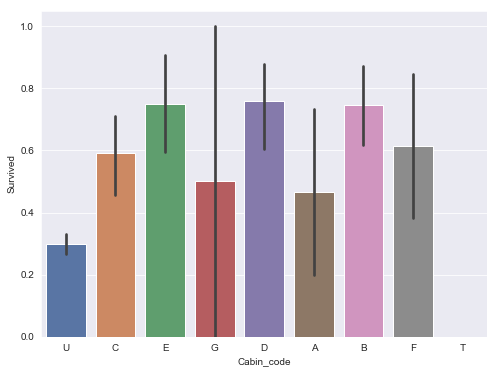

In [15]:
# Cabin
# we can see lots of missing value here, but how relevant is it? Should we discard this variable?
dataset['Cabin'][dataset['Cabin'].isnull()]='U'
dataset['Has_Cabin'] = dataset['Cabin'].apply(lambda x : 0 if x== 'U' else 1)
dataset['Has_Cabin'] = dataset['Has_Cabin'].apply(str)
sns.barplot(x ='Has_Cabin',y = 'Survived',data = dataset)
plt.show()
# People with cabin have higher survival rate, thus this variable is highly relevant

# Do people in different Cabin_code have different survival rate？
dataset['Cabin_code'] = dataset['Cabin'].str.get(0)
sns.barplot(x ='Cabin_code',y='Survived',data = dataset,estimator=np.mean)
plt.show()
#different cabin_code has different survival rate, so we can classify them into
#three groups: 0(U),1(CGAF),2(EDB)

In [16]:
# Title
Title_dict = dict()
Title_dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'],'Officer'))
Title_dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'],'Royalty'))
Title_dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'],'Mrs'))
Title_dict.update(dict.fromkeys(['Mlle', 'Miss'],'Miss'))
Title_dict.update(dict.fromkeys(['Mr'],'Mr'))
Title_dict.update(dict.fromkeys(['Master','Jonkheer'],'Master'))
dataset['Title'] = dataset['Title'].map(Title_dict)


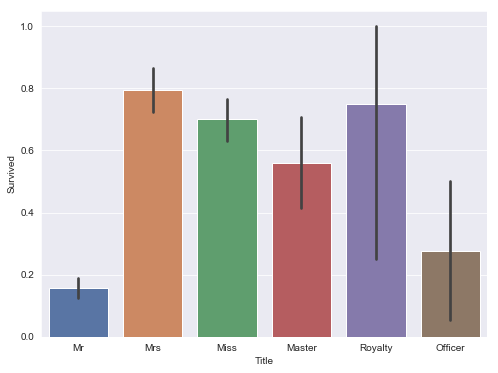

In [17]:
sns.barplot('Title','Survived',data = dataset)
plt.show()
# different title has different survival rate, Mr has the lowest likelihood to survive.

In [18]:
# Ticket
ticket_counts = dataset['Ticket'].value_counts()
ticket_unique =list(dataset['Ticket'].unique())
ticket_dict = dict()
for i in range(0,len(ticket_unique)):
    ticket_dict.update(dict.fromkeys([ticket_unique[i]],ticket_counts.loc[ticket_unique[i],]))
dataset['Ticket'] = dataset['Ticket'].map(ticket_dict).apply(str) 

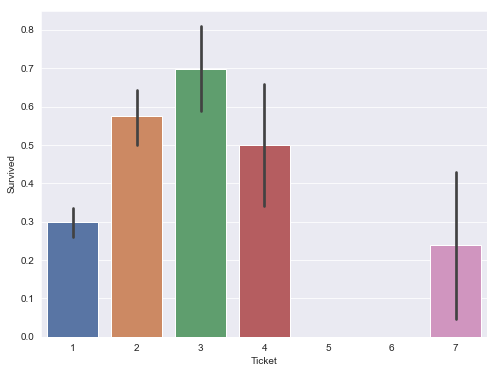

In [19]:
sns.barplot(x ='Ticket',y='Survived',data = dataset)
plt.show()
# same phenomenon as family size, the same ticket number may be bought by the family.

In [20]:
# divide Tickets into two classes
dataset['Ticket_nums'] = dataset['Ticket'].apply(int)  #2-4:1  1,5,6,7:0 
dataset['Ticket_nums'][(dataset['Ticket_nums']==1)|(dataset['Ticket_nums']>=5)]=0 #1,5,6,7
dataset['Ticket_nums'][(dataset['Ticket_nums']>=2)&(dataset['Ticket_nums']<=4)]=1 #2,3,4

E:\MNCD\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\MNCD\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [21]:
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Child,FamilySize,Has_Cabin,Cabin_code,Ticket_nums
0,0,3,male,22.0,1,0,1,0.0,U,S,Mr,2,adult,2,0,U,0
1,1,1,female,38.0,1,0,1,1.0,C85,C,Mrs,1,adult,2,1,C,0
2,1,3,female,26.0,0,0,1,0.0,U,S,Miss,1,adult,1,0,U,0
3,1,1,female,35.0,1,0,2,1.0,C123,S,Mrs,2,adult,2,1,C,1
4,0,3,male,35.0,0,0,1,0.0,U,S,Mr,2,adult,1,0,U,0


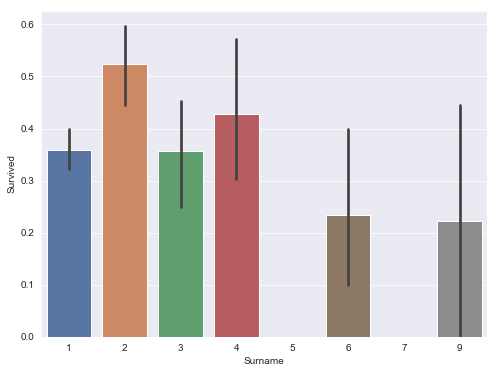

In [22]:
sns.barplot(x = 'Surname',y = 'Survived',data=dataset)
plt.show()

In [23]:
dataset['Surname'][dataset['Surname']==9]

13     9
68     9
119    9
146    9
541    9
542    9
610    9
813    9
850    9
Name: Surname, dtype: int64

In [24]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
Surname        891 non-null int64
Child          891 non-null object
FamilySize     891 non-null object
Has_Cabin      891 non-null object
Cabin_code     891 non-null object
Ticket_nums    891 non-null int64
dtypes: float64(2), int64(6), object(9)
memory usage: 118.4+ KB
